จัดการ Parameter ของโมเดล และสร้าง Optimizer สำหรับอัพเดท Parameter ตามอัลกอริทึมต่าง ๆ โดย[เริ่มต้น Refactor ที่หัวข้อ 6](#6.-Refactor-ส่วน-x,-y)

# 0. Magic

In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Import

In [0]:
import torch
from torch import tensor
from torch import nn
import torch.nn.functional as F
from torch.utils import data 
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
from fastai.metrics import accuracy
import pickle, gzip, math, torch
import operator

# 2. Data

In [0]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

# 3. เตรียม Data

In [0]:
class Dataset(data.Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
# x = data, m = mean, s = standard deviation
def normalize(x, m, s): 
    return (x-m)/s

In [40]:
n, m = x_train.shape
c = y_train.max()+1
n, m, c

(50000, 784, tensor(10))

In [0]:
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [0]:
# batch size
bs = 64
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
train_dl, valid_dl = data.DataLoader(train_ds, bs), data.DataLoader(valid_ds, bs)

# 4. สร้าง Model

โมเดลจะประกอบด้วยส่วนต่าง ๆ เช่น Architecture กำหนด Layers ต่าง ๆ, Initialization, Loss Function, อัลกอริทึมในการเทรน และ Metrics ที่เราเรียนรู้กันไปใน ep ก่อน ๆ 

โมเดล

In [0]:
class Model():
    def __init__(self, n_in, nh, n_out):
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
    def __call__(self, x):
#         set_trace()
        for l in self.layers:
            x = l(x)
        return x
    def backward(self):
        self.loss.backward()        
        for l in reversed(self.layers):
            l.backward()

In [0]:
def get_model():
    # loss function
    loss_func = F.cross_entropy
    model = Model(m, nh, c.numpy())
    return model, loss_func

กำหนด Hyperparameter

In [0]:
# learning rate
lr = 0.03
epoch = 1
nh = 50

In [0]:
# model, loss_func = get_model()

# 5. Training Loop

เราจะเทรนโมเดล ด้วยอัลกอริทึม [Stochastic Gradient Descent (SGD)](https://www.bualabs.com/wp-admin/post.php?post=631&action=edit) และ เก็บ Loss, Accuracy เอาไว้พล็อตกราฟ

ประกาศฟังก์ชัน fit เอาไว้เรียกเทรนเวลาที่ต้องการ

In [0]:
def fit():
    losses, metrics = [], []
    # e = epoch number
    for e in range(epoch):
        for xb, yb in train_dl:

            # Feedforward
            yhatb = model(xb)
            loss = loss_func(yhatb, yb)

            # Metrics
            acc = accuracy(yhatb, yb)
            losses.append(loss); metrics.append(acc)

            # Backpropagation
            loss.backward()

            # Update Wight and Bias with SGD
            with torch.no_grad():
                for l in model.layers:
                    if hasattr(l, 'weight'):
                        l.weight -= l.weight.grad * lr
                        l.bias   -= l.bias.grad * lr 
                        l.weight.grad.zero_()
                        l.bias.grad.zero_()       

    plot_metrics(losses, metrics)

ประการฟัง์ชัน ไว้พล็อตกราฟ Loss และ Accuracy

In [0]:
def plot_metrics(losses, metrics):
    x = torch.arange(len(losses)).numpy()
    fig,ax = plt.subplots(figsize=(9, 9))
    ax.grid(True)
    ax.plot(x, losses, label="Loss")
    ax.plot(x, metrics, label="Accuracy")
    ax.legend(loc='upper right')

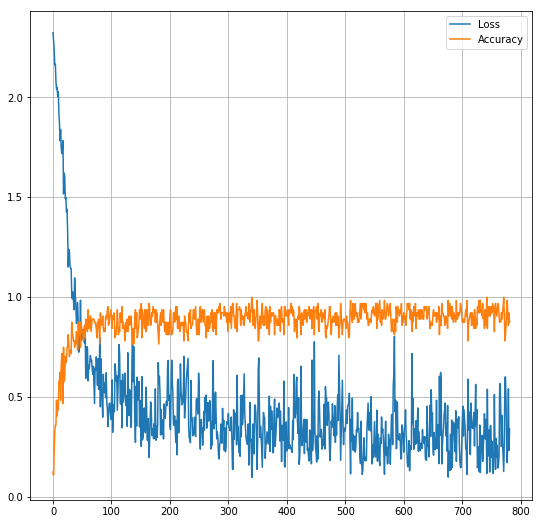

In [59]:
model, loss_func = get_model()
fit()

# 6. Refactor Model ไป subclass จาก nn.Module

Refactor ในส่วน Backpropagation ของ Model ไปใช้ของ PyTorch nn.Module ทำให้โค้ดสั้นลง

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.Linear(nh, n_out)]
    def __call__(x):
        for l in self.layers:
            x = l(x)
        return x


In [0]:
model, _ = get_model()

In [75]:
fit()

TypeError: ignored

In [0]:
for l in model.named_children(): print(l)

แต่การประกาศ Layer เป็น Instance Variable ทำให้โมเดลไม่ยืดหยุ่น ไม่สามารถเพิ่ม Layer ได้แบบ Dynamic

# 8. สรุป

1. ฟฟฟ


# Credit 

* https://course.fast.ai/videos/?lesson=9
* https://pytorch.org/docs/stable/data.html